# Initialize

In [1]:
import tensorflow as tf
print(tf.__version__)

# Check for GPU avilablity
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

2.10.0
Default GPU Device: /device:GPU:0


In [2]:
# Print list of avilable GPU
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

# Set GPU
tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Imports

import warnings
warnings.filterwarnings('ignore')

import os

import numpy as np
import pandas as pd

import rasterio
import earthpy.plot as ep

In [4]:
# Get and print the current working directory
current_dir = os.getcwd()
print('Current Working Directory:', current_dir)

# Update and print current working directory
temp_dirpath = os.path.join('D:\\', 'Akshaya')
os.chdir(temp_dirpath)
updated_current_dir = os.getcwd()
print("Updated Current Working Directory:", updated_current_dir)

# Set and print the raw DATA directory
rawDATA_dir = os.path.join(updated_current_dir, 'DATA')
print('Raw DATA Directory:', rawDATA_dir)

# Set and print the Output directory
output_dir = os.path.join(updated_current_dir, 'LULC_dataset', 'jupyterNB_outputs')
print('Output Directory:', output_dir) 

Current Working Directory: D:\Akshaya\LULC_dataset
Updated Current Working Directory: D:\Akshaya
Raw DATA Directory: D:\Akshaya\DATA
Output Directory: D:\Akshaya\LULC_dataset\jupyterNB_outputs


In [5]:
# Funtion to create a new folder at specified folder path
def create_folder(folder_path, folder_name):
    try:
        # Join folder path and folder name to create the full path
        full_path = os.path.join(folder_path, folder_name)
        
        # Check if the folder already exists
        if not os.path.exists(full_path):
            # Create the folder
            os.makedirs(full_path)
            print(f"Folder '{folder_name}' created successfully at '{folder_path}'.")
        else:
            print(f"Folder '{folder_name}' already exists at '{folder_path}'.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")     
    return full_path
        
# Create and print Output directory for the current jupyterNB
current_output_dir = create_folder(folder_path=output_dir, folder_name='04_CNN2023new')
print('Current jupyterNB Output Directory:', current_output_dir)

Folder '04_CNN2023new' created successfully at 'D:\Akshaya\LULC_dataset\jupyterNB_outputs'.
Current jupyterNB Output Directory: D:\Akshaya\LULC_dataset\jupyterNB_outputs\04_CNN2023new


In [6]:
# Import packages
import pandas as pd
import numpy as np
import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import Model
import rasterio
import earthpy.plot as ep
from keras.utils import to_categorical, plot_model, model_to_dot
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors

# Import dataset

In [7]:
# Set 'Samples_LC_2023.csv' shapefile filepath
SAMPLE_PATH = os.path.join(rawDATA_dir, 'DLnew', 'Samples_LC_2023new.csv')
print(SAMPLE_PATH)

# Read 'Samples_LC_2023.csv' using pandas
samples = pd.read_csv(SAMPLE_PATH)
print(samples.shape)
samples.head()

D:\Akshaya\DATA\DLnew\Samples_LC_2023new.csv
(215902, 19)


,B2,B3,B4,B8,B11,B12,B5,B6,B7,EVI,NDVI,NBR,NDMI,NDWI,NDBI,NDBaI,elevation,classvalue,sample
0,1176.0,1450.0,1838.0,2248.0,3216.0,2966.0,2010.0,2050.0,2193.0,0.229975,0.100343,-0.137706,-0.177160,-0.215792,0.177160,0.272655,49,0,train
1,1288.0,1578.0,1944.0,2237.0,3167.0,2955.0,2113.0,2203.0,2358.0,0.172678,0.070079,-0.138290,-0.172095,-0.172739,0.172095,0.239288,49,0,train
2,1406.0,1698.0,2072.0,2316.0,3167.0,2955.0,2113.0,2203.0,2358.0,0.145100,0.055606,-0.121229,-0.155207,-0.153961,0.155207,0.209009,48,0,train
3,1112.0,1444.0,1820.0,2242.0,3152.0,2947.0,2134.0,2256.0,2423.0,0.218744,0.103890,-0.135864,-0.168706,-0.216495,0.168706,0.267900,48,0,train
4,1046.0,1416.0,1866.0,2258.0,3152.0,2947.0,2134.0,2256.0,2423.0,0.174688,0.095053,-0.132373,-0.165250,-0.229178,0.165250,0.256277,48,0,train


In [8]:
# Set 'Sentinel_2023_feature_selected.tif' image filepath
IMAGE_PATH = os.path.join(rawDATA_dir, 'DL2', 'Sentinel_2023_feature_selected.tif')
print(IMAGE_PATH)
# Load image
image_feature_selected = rasterio.open(IMAGE_PATH)

# Get basic metadata
band_num = image_feature_selected.count
height = image_feature_selected.height
width = image_feature_selected.width
crs = image_feature_selected.crs
transform = image_feature_selected.transform
shape = (height, width)

# Get band names (descriptions)
band_names = image_feature_selected.descriptions

print(f"Number of bands: {band_num}")
print(f"Height: {height}")
print(f"Width: {width}")
print(f"CRS: {crs}")
print(f"Transform: {transform}")
print(f"Shape: {shape}")
print(f"Band names: {band_names}")

D:\Akshaya\DATA\DL2\Sentinel_2023_feature_selected.tif
Number of bands: 17
Height: 3877
Width: 4916
CRS: EPSG:4326
Transform: | 0.00, 0.00, 77.68|
| 0.00,-0.00, 8.90|
| 0.00, 0.00, 1.00|
Shape: (3877, 4916)
Band names: ('B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'B5', 'B6', 'B7', 'EVI', 'NDVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation')


In [9]:
# # Polt 'Sentinel_2023_feature_selected.tif' image
# image_vis = []
# for x in [3, 2, 1]:
#     image_vis.append(image_feature_selected.read(x))
# image_vis = np.stack(image_vis)

# # Plot the RGB image
# plot_size = (8, 8)
# fig, ax = plt.subplots(figsize=plot_size)
# ep.plot_rgb(image_vis, ax=ax, stretch=True)
# ax.set_title('Sentinel_2023 RGB Composite')  # Set the title
# # Save the plot as a JPEG file
# plt.savefig(os.path.join(current_output_dir, 'Sentinel_2023_RGB_Composite.jpg'), format='jpeg')
# # Display the plot
# plt.show();

# Train-test split

In [10]:
# Set Parameters
FEATURES = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'B5', 'B6', 'B7', 'EVI', 'NDVI', 'NBR', 'NDMI', 'NDWI', 'NDBI', 'NDBaI', 'elevation']
LABEL = ['classvalue']
SPLIT = ['sample']
N_CLASSES = 6
CLASSES = [0, 1, 2, 3, 4, 5]
CLASS_NAME = ['Built Up', 'Agricultural land', 'Wastelands', 'Water bodies', 'Wetlands', 'Forest']
PALETTE = ['#FF000D', '#CCFF00', '#D8863B', '#4800FF', '#00FFFF', '#228B22']

print(len(FEATURES), len(CLASSES), len(CLASS_NAME), len(PALETTE))

17 6 6 6


In [11]:
from sklearn.model_selection import train_test_split
X = samples[FEATURES]
y = samples[LABEL]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(172721, 17) (172721, 1)
(43181, 17) (43181, 1)


In [12]:
# Split between features and label
train_features = X_train
train_label = y_train
test_features = X_test
test_label = y_test

# Function to reshape array input
def reshape_input(array):
    shape = array.shape
    return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), N_CLASSES+1, int)
test_output = to_categorical(test_label.to_numpy(), N_CLASSES+1, int)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (172721, 17, 1)
Test features: (43181, 17, 1)
Train label: (172721, 7)
Test label: (43181, 7)


# MODEL

In [13]:
from tensorflow.keras import layers, Model

In [14]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.2
kernel = 2
pool = 2

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES+1, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 16, 64)            192       
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 64)            8256      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 64)            0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 7, 64)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 6, 128)            16512     
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 128)            32896     
                                                        

In [15]:
# Compline the model
model.compile(optimizer='Adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

# Create callback to stop training if loss not decreasing
callbacks = [EarlyStopping(monitor='loss', patience=3)]

# Fit the model
result = model.fit(x=train_input, y=train_output, validation_data=(test_input, test_output), 
                   batch_size=1024, callbacks=callbacks, epochs=20)

Epoch 1/20
169/169 [==============================] - 11s 17ms/step - loss: 5.6315 - accuracy: 0.5594 - val_loss: 0.6486 - val_accuracy: 0.7798
Epoch 2/20
169/169 [==============================] - 2s 10ms/step - loss: 0.6925 - accuracy: 0.7480 - val_loss: 0.4744 - val_accuracy: 0.8164
Epoch 3/20
169/169 [==============================] - 2s 10ms/step - loss: 0.5228 - accuracy: 0.7969 - val_loss: 0.3601 - val_accuracy: 0.8444
Epoch 4/20
169/169 [==============================] - 2s 14ms/step - loss: 0.4451 - accuracy: 0.8222 - val_loss: 0.3253 - val_accuracy: 0.8645
Epoch 5/20
169/169 [==============================] - 2s 9ms/step - loss: 0.4032 - accuracy: 0.8391 - val_loss: 0.2953 - val_accuracy: 0.8723
Epoch 6/20
169/169 [==============================] - 2s 9ms/step - loss: 0.3694 - accuracy: 0.8557 - val_loss: 0.2592 - val_accuracy: 0.9115
Epoch 7/20
169/169 [==============================] - 2s 10ms/step - loss: 0.3365 - accuracy: 0.8720 - val_loss: 0.2643 - val_accuracy: 0.9090


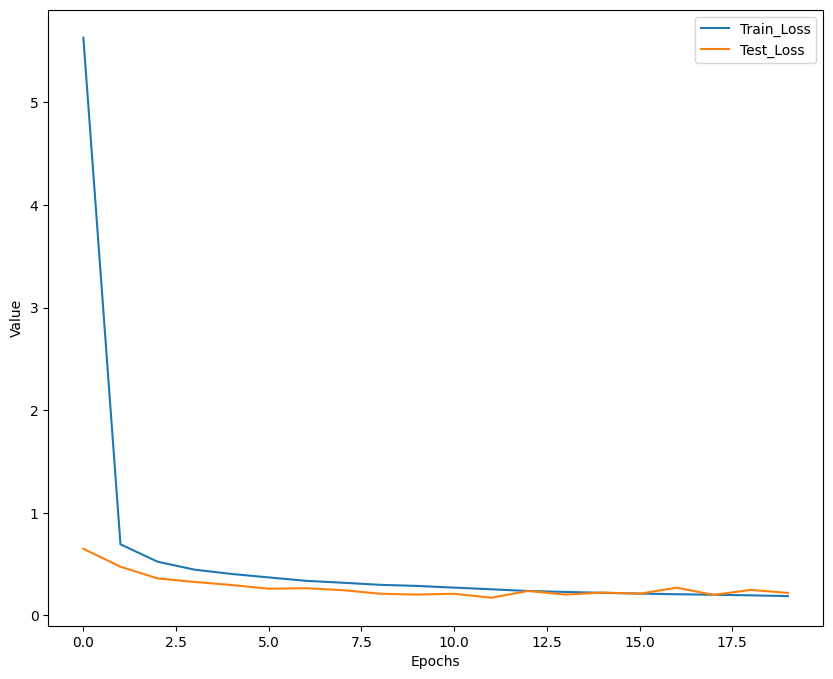

In [16]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
# plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
# plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
# Save the plot as a JPEG file
plt.savefig(os.path.join(current_output_dir, 'Sentinel_2023.jpg'), format='jpeg')
plt.show()

In [17]:
# Predict test data
prediction = np.argmax(model.predict(test_input), axis=1).flatten()
label = np.argmax(test_output, axis=1).flatten()

# Classification report
print(classification_report(label, prediction))

1350/1350 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.64      0.78      5336
           1       0.83      0.89      0.86     10229
           2       0.94      0.77      0.85       799
           3       0.78      0.96      0.86      1366
           4       0.99      0.92      0.95      4226
           5       0.94      0.99      0.96     21225

    accuracy                           0.91     43181
   macro avg       0.91      0.86      0.88     43181
weighted avg       0.92      0.91      0.91     43181



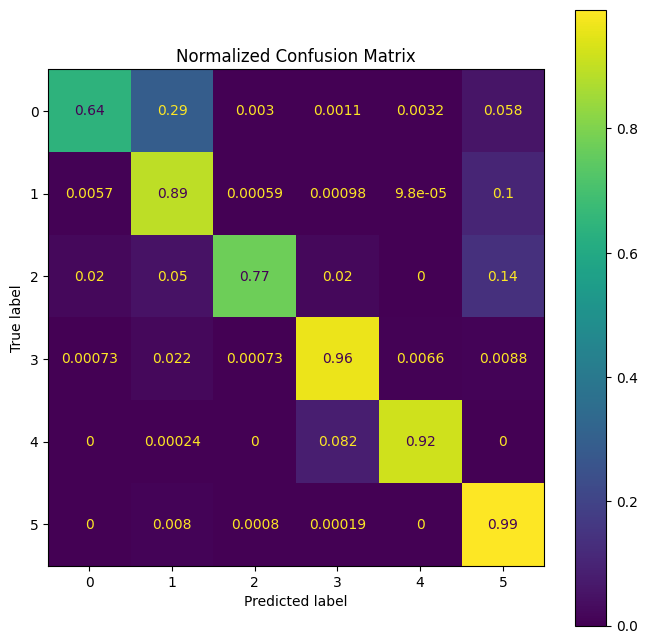

In [18]:
# Confusion matrix
cm = confusion_matrix(label, prediction, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
ax.set_title('Normalized Confusion Matrix')  # Set the title
# Save the plot as a JPEG file
plt.savefig(os.path.join(current_output_dir, 'Normalized_Confusion_Matrix.jpg'), format='jpeg')
# Display the plot
plt.show();

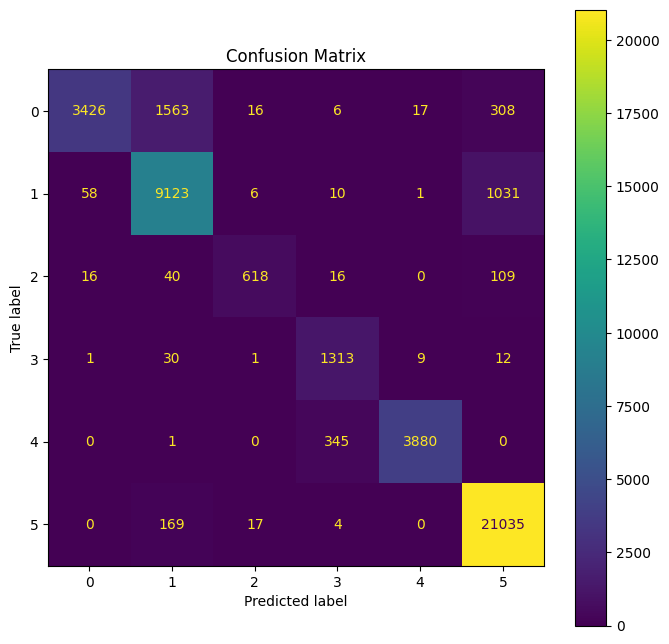

In [19]:
# Confusion matrix
cm = confusion_matrix(label, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax)
ax.set_title('Confusion Matrix')  # Set the title
# Save the plot as a JPEG file
plt.savefig(os.path.join(current_output_dir, 'Confusion_Matrix.jpg'), format='jpeg')
# Display the plot
plt.show();

# Prediction

In [20]:
# Predict image using the model
image_input = []
for x in range(len(FEATURES)):
    image_input.append(image_feature_selected.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(len(FEATURES), -1).T)

In [21]:
print(shape, image_input.shape)

(3877, 4916) (19059332, 17, 1)


In [22]:
# # Predict
# prediction = model.predict(image_input)
# prediction = np.argmax(prediction, 1)
# prediction = prediction.reshape(shape[0], shape[1])

In [23]:
19059332 / 15508

1229.0

In [24]:
pred_lst = []

i = 1
n = 15508
while (i<=1229): 
    start = n * (i-1)
    stop = (n * i)
    print (i, start, stop)
    i += 1

    temp_prediction = model.predict(image_input[start:stop], batch_size=7754)
    temp_prediction = np.argmax(temp_prediction, 1)
    pred_lst.append(temp_prediction)

1 0 15508
2/2 [==============================] - 1s 8ms/step
2 15508 31016
2/2 [==============================] - 0s 9ms/step
3 31016 46524
2/2 [==============================] - 0s 10ms/step
4 46524 62032
2/2 [==============================] - 0s 10ms/step
5 62032 77540
2/2 [==============================] - 0s 10ms/step
6 77540 93048
2/2 [==============================] - 0s 11ms/step
7 93048 108556
2/2 [==============================] - 0s 9ms/step
8 108556 124064
2/2 [==============================] - 0s 10ms/step
9 124064 139572
2/2 [==============================] - 0s 9ms/step
10 139572 155080
2/2 [==============================] - 0s 11ms/step
11 155080 170588
2/2 [==============================] - 0s 10ms/step
12 170588 186096
2/2 [==============================] - 0s 11ms/step
13 186096 201604
2/2 [==============================] - 0s 10ms/step
14 201604 217112
2/2 [==============================] - 0s 10ms/step
15 217112 232620
2/2 [==============================] - 0s 11ms/

2/2 [==============================] - 0s 15ms/step
119 1829944 1845452
2/2 [==============================] - 0s 15ms/step
120 1845452 1860960
2/2 [==============================] - 0s 15ms/step
121 1860960 1876468
2/2 [==============================] - 0s 15ms/step
122 1876468 1891976
2/2 [==============================] - 0s 15ms/step
123 1891976 1907484
2/2 [==============================] - 0s 15ms/step
124 1907484 1922992
2/2 [==============================] - 0s 14ms/step
125 1922992 1938500
2/2 [==============================] - 0s 14ms/step
126 1938500 1954008
2/2 [==============================] - 0s 14ms/step
127 1954008 1969516
2/2 [==============================] - 0s 15ms/step
128 1969516 1985024
2/2 [==============================] - 0s 15ms/step
129 1985024 2000532
2/2 [==============================] - 0s 15ms/step
130 2000532 2016040
2/2 [==============================] - 0s 15ms/step
131 2016040 2031548
2/2 [==============================] - 0s 15ms/step
132 2031548 

2/2 [==============================] - 0s 15ms/step
233 3597856 3613364
2/2 [==============================] - 0s 15ms/step
234 3613364 3628872
2/2 [==============================] - 0s 15ms/step
235 3628872 3644380
2/2 [==============================] - 0s 15ms/step
236 3644380 3659888
2/2 [==============================] - 0s 14ms/step
237 3659888 3675396
2/2 [==============================] - 0s 14ms/step
238 3675396 3690904
2/2 [==============================] - 0s 14ms/step
239 3690904 3706412
2/2 [==============================] - 0s 15ms/step
240 3706412 3721920
2/2 [==============================] - 0s 16ms/step
241 3721920 3737428
2/2 [==============================] - 0s 14ms/step
242 3737428 3752936
2/2 [==============================] - 0s 15ms/step
243 3752936 3768444
2/2 [==============================] - 0s 15ms/step
244 3768444 3783952
2/2 [==============================] - 0s 15ms/step
245 3783952 3799460
2/2 [==============================] - 0s 15ms/step
246 3799460 

2/2 [==============================] - 0s 15ms/step
347 5365768 5381276
2/2 [==============================] - 0s 15ms/step
348 5381276 5396784
2/2 [==============================] - 0s 15ms/step
349 5396784 5412292
2/2 [==============================] - 0s 15ms/step
350 5412292 5427800
2/2 [==============================] - 0s 15ms/step
351 5427800 5443308
2/2 [==============================] - 0s 15ms/step
352 5443308 5458816
2/2 [==============================] - 0s 15ms/step
353 5458816 5474324
2/2 [==============================] - 0s 15ms/step
354 5474324 5489832
2/2 [==============================] - 0s 15ms/step
355 5489832 5505340
2/2 [==============================] - 0s 15ms/step
356 5505340 5520848
2/2 [==============================] - 0s 15ms/step
357 5520848 5536356
2/2 [==============================] - 0s 15ms/step
358 5536356 5551864
2/2 [==============================] - 0s 15ms/step
359 5551864 5567372
2/2 [==============================] - 0s 15ms/step
360 5567372 

2/2 [==============================] - 0s 14ms/step
461 7133680 7149188
2/2 [==============================] - 0s 15ms/step
462 7149188 7164696
2/2 [==============================] - 0s 15ms/step
463 7164696 7180204
2/2 [==============================] - 0s 15ms/step
464 7180204 7195712
2/2 [==============================] - 0s 14ms/step
465 7195712 7211220
2/2 [==============================] - 0s 14ms/step
466 7211220 7226728
2/2 [==============================] - 0s 15ms/step
467 7226728 7242236
2/2 [==============================] - 0s 15ms/step
468 7242236 7257744
2/2 [==============================] - 0s 15ms/step
469 7257744 7273252
2/2 [==============================] - 0s 15ms/step
470 7273252 7288760
2/2 [==============================] - 0s 15ms/step
471 7288760 7304268
2/2 [==============================] - 0s 15ms/step
472 7304268 7319776
2/2 [==============================] - 0s 15ms/step
473 7319776 7335284
2/2 [==============================] - 0s 15ms/step
474 7335284 

2/2 [==============================] - 0s 15ms/step
575 8901592 8917100
2/2 [==============================] - 0s 14ms/step
576 8917100 8932608
2/2 [==============================] - 0s 14ms/step
577 8932608 8948116
2/2 [==============================] - 0s 15ms/step
578 8948116 8963624
2/2 [==============================] - 0s 14ms/step
579 8963624 8979132
2/2 [==============================] - 0s 15ms/step
580 8979132 8994640
2/2 [==============================] - 0s 15ms/step
581 8994640 9010148
2/2 [==============================] - 0s 14ms/step
582 9010148 9025656
2/2 [==============================] - 0s 14ms/step
583 9025656 9041164
2/2 [==============================] - 0s 14ms/step
584 9041164 9056672
2/2 [==============================] - 0s 14ms/step
585 9056672 9072180
2/2 [==============================] - 0s 14ms/step
586 9072180 9087688
2/2 [==============================] - 0s 15ms/step
587 9087688 9103196
2/2 [==============================] - 0s 15ms/step
588 9103196 

2/2 [==============================] - 0s 16ms/step
687 10638488 10653996
2/2 [==============================] - 0s 15ms/step
688 10653996 10669504
2/2 [==============================] - 0s 15ms/step
689 10669504 10685012
2/2 [==============================] - 0s 14ms/step
690 10685012 10700520
2/2 [==============================] - 0s 15ms/step
691 10700520 10716028
2/2 [==============================] - 0s 15ms/step
692 10716028 10731536
2/2 [==============================] - 0s 15ms/step
693 10731536 10747044
2/2 [==============================] - 0s 15ms/step
694 10747044 10762552
2/2 [==============================] - 0s 15ms/step
695 10762552 10778060
2/2 [==============================] - 0s 15ms/step
696 10778060 10793568
2/2 [==============================] - 0s 15ms/step
697 10793568 10809076
2/2 [==============================] - 0s 15ms/step
698 10809076 10824584
2/2 [==============================] - 0s 14ms/step
699 10824584 10840092
2/2 [==============================] -

2/2 [==============================] - 0s 15ms/step
798 12359876 12375384
2/2 [==============================] - 0s 15ms/step
799 12375384 12390892
2/2 [==============================] - 0s 15ms/step
800 12390892 12406400
2/2 [==============================] - 0s 15ms/step
801 12406400 12421908
2/2 [==============================] - 0s 16ms/step
802 12421908 12437416
2/2 [==============================] - 0s 14ms/step
803 12437416 12452924
2/2 [==============================] - 0s 14ms/step
804 12452924 12468432
2/2 [==============================] - 0s 15ms/step
805 12468432 12483940
2/2 [==============================] - 0s 15ms/step
806 12483940 12499448
2/2 [==============================] - 0s 15ms/step
807 12499448 12514956
2/2 [==============================] - 0s 15ms/step
808 12514956 12530464
2/2 [==============================] - 0s 14ms/step
809 12530464 12545972
2/2 [==============================] - 0s 15ms/step
810 12545972 12561480
2/2 [==============================] -

2/2 [==============================] - 0s 15ms/step
909 14081264 14096772
2/2 [==============================] - 0s 15ms/step
910 14096772 14112280
2/2 [==============================] - 0s 14ms/step
911 14112280 14127788
2/2 [==============================] - 0s 15ms/step
912 14127788 14143296
2/2 [==============================] - 0s 15ms/step
913 14143296 14158804
2/2 [==============================] - 0s 15ms/step
914 14158804 14174312
2/2 [==============================] - 0s 15ms/step
915 14174312 14189820
2/2 [==============================] - 0s 15ms/step
916 14189820 14205328
2/2 [==============================] - 0s 15ms/step
917 14205328 14220836
2/2 [==============================] - 0s 14ms/step
918 14220836 14236344
2/2 [==============================] - 0s 15ms/step
919 14236344 14251852
2/2 [==============================] - 0s 15ms/step
920 14251852 14267360
2/2 [==============================] - 0s 15ms/step
921 14267360 14282868
2/2 [==============================] -

2/2 [==============================] - 0s 15ms/step
1019 15787144 15802652
2/2 [==============================] - 0s 15ms/step
1020 15802652 15818160
2/2 [==============================] - 0s 15ms/step
1021 15818160 15833668
2/2 [==============================] - 0s 15ms/step
1022 15833668 15849176
2/2 [==============================] - 0s 15ms/step
1023 15849176 15864684
2/2 [==============================] - 0s 15ms/step
1024 15864684 15880192
2/2 [==============================] - 0s 15ms/step
1025 15880192 15895700
2/2 [==============================] - 0s 15ms/step
1026 15895700 15911208
2/2 [==============================] - 0s 15ms/step
1027 15911208 15926716
2/2 [==============================] - 0s 16ms/step
1028 15926716 15942224
2/2 [==============================] - 0s 15ms/step
1029 15942224 15957732
2/2 [==============================] - 0s 15ms/step
1030 15957732 15973240
2/2 [==============================] - 0s 15ms/step
1031 15973240 15988748
2/2 [====================

2/2 [==============================] - 0s 15ms/step
1128 17477516 17493024
2/2 [==============================] - 0s 15ms/step
1129 17493024 17508532
2/2 [==============================] - 0s 15ms/step
1130 17508532 17524040
2/2 [==============================] - 0s 15ms/step
1131 17524040 17539548
2/2 [==============================] - 0s 15ms/step
1132 17539548 17555056
2/2 [==============================] - 0s 15ms/step
1133 17555056 17570564
2/2 [==============================] - 0s 15ms/step
1134 17570564 17586072
2/2 [==============================] - 0s 15ms/step
1135 17586072 17601580
2/2 [==============================] - 0s 15ms/step
1136 17601580 17617088
2/2 [==============================] - 0s 15ms/step
1137 17617088 17632596
2/2 [==============================] - 0s 14ms/step
1138 17632596 17648104
2/2 [==============================] - 0s 15ms/step
1139 17648104 17663612
2/2 [==============================] - 0s 15ms/step
1140 17663612 17679120
2/2 [====================

In [25]:
prediction = np.concatenate(pred_lst).reshape(shape[0], shape[1])
prediction.shape

(3877, 4916)

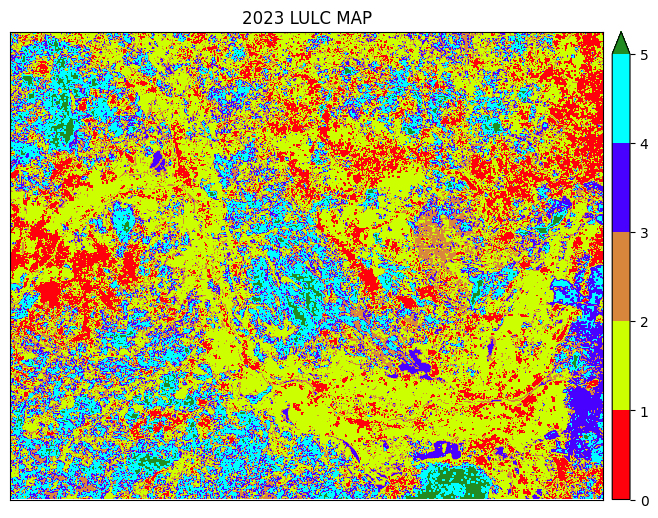

In [26]:
# Create colormap and normalization from class values and colors
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')

# Plot the prediction
plot_size = (8, 8)  # Define the plot size
fig, ax = plt.subplots(figsize=plot_size)
ep.plot_bands(prediction, cmap=cmap, norm=norm, ax=ax)
ax.set_title('2023 LULC MAP')

# Save the plot as a JPEG file
plt.savefig(os.path.join(current_output_dir, 'lulc_2023.jpg'), format='jpeg')

# Display the plot
plt.show()

In [27]:
# Save the prediction as a GeoTIFF using properties from an existing satellite image
# Load the existing satellite image
with rasterio.open(IMAGE_PATH) as src:
    # Copy metadata
    meta = src.meta.copy()
    meta.update({
        'dtype': 'int32',  # Assuming the prediction values are integer
        'count': 1
    })

    # Save the prediction array as a GeoTIFF
    with rasterio.open(os.path.join(current_output_dir, 'lulc_2023.tif'), 'w', **meta) as dst:
        dst.write(prediction.astype(rasterio.int32), 1)